<h1 style="font-size:400%">FRUIT DETECTOR</h1>

This notebook is a demonstration of using [PyTorch Lightning](https://lightning.ai/pytorch-lightning) and transfer learning to fine tune a pretrained model for object detection to detect fruits. The data for this example is included in the git repo, so you can just clone this repo and run the notebook.

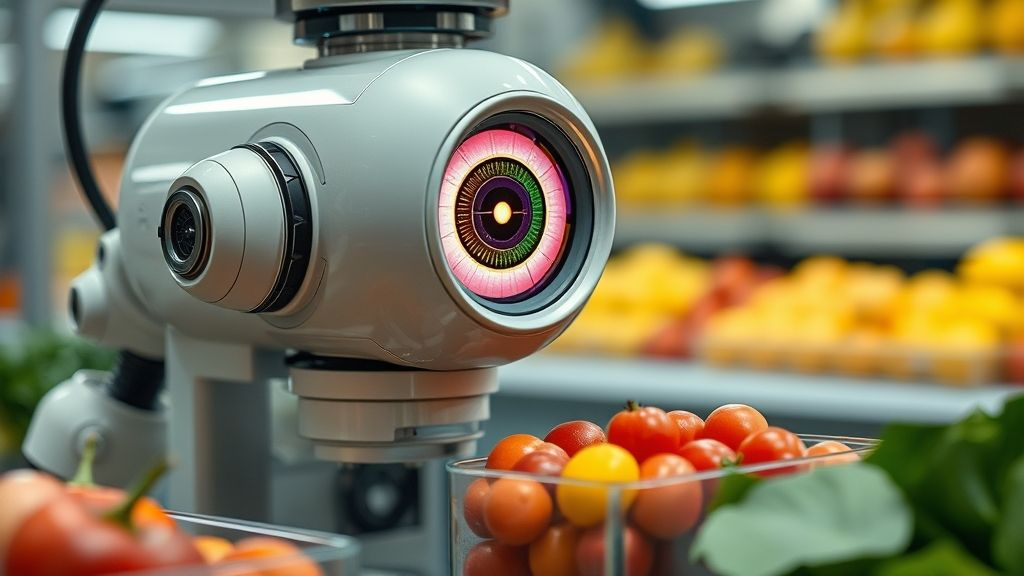

In [1]:
import os, pandas, platform, torch, torchvision, pytorch_lightning
import matplotlib.pyplot as plt

torch.manual_seed(42)

data_path = "dataset/data"
inference_path = "dataset/inference"

print("Versions: python", platform.python_version(), "| torch", torch.__version__, "| torchvision", torchvision.__version__, "| pytorch_lightning", pytorch_lightning.__version__, "| pandas", pandas.__version__)

Versions: python 3.10.11 | torch 2.4.1+cu121 | torchvision 0.19.1+cu121 | pytorch_lightning 2.5.0.post0 | pandas 2.2.1


# Loading a pre-trained model


In [2]:
from torchvision.models import detection

pretrained_model = detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights="DEFAULT")

# Prepare the dataset



In [3]:
from torchvision import transforms
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
from PIL import Image

class ObjectDetectionDataset(Dataset):
    def __init__(self, path, image_size=(320, 320)):
        self.path = path
        self.image_size = image_size
        self.annotations = [f for f in os.listdir(path) if f.endswith(".xml")]
        names = [o.find("name").text 
            for a in self.annotations 
            for o in ET.parse(os.path.join(self.path, a)).getroot().findall("object")]
        self.classes = ["__background__"] + list(set(names))

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        image = Image.open(os.path.join(self.path, self.annotations[index].replace(".xml", ".jpg"))).convert("RGB")
        w, h = image.size
        x_scale, y_scale = self.image_size[0] / w, self.image_size[1] / h
        image = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),
        ])(image)
        labels, boxes = [], []
        for obj in ET.parse(os.path.join(self.path, self.annotations[index])).getroot().findall("object"):
            labels.append(self.classes.index(obj.find('name').text))
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text) * x_scale
            ymin = int(bbox.find('ymin').text) * y_scale
            xmax = int(bbox.find('xmax').text) * x_scale
            ymax = int(bbox.find('ymax').text) * y_scale
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.empty((0, 4), dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64) if labels else torch.empty((0,), dtype=torch.int64)
        return image, {"boxes": boxes, "labels": labels}


dataset = ObjectDetectionDataset(data_path)
print("Created a dataset with", len(dataset), "images and the following classes:", dataset.classes)

Created a dataset with 275 images and the following classes: ['__background__', 'banana', 'orange', 'apple']


# Sample the data

This is just a random sample of images and their labels. 

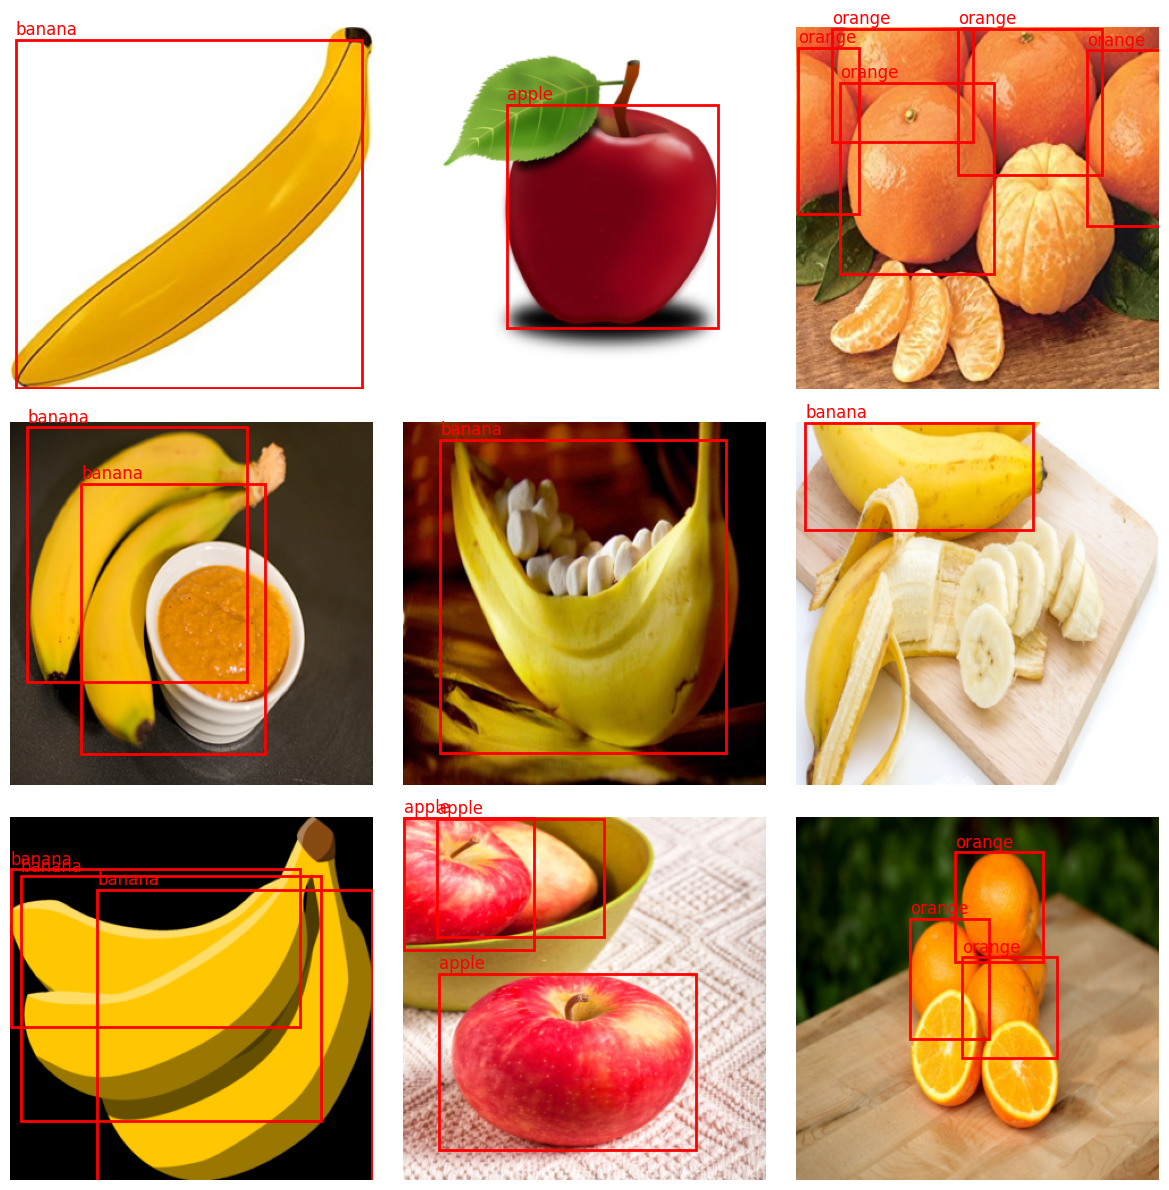

In [4]:
import random
from matplotlib import patches

indices = random.sample(range(len(dataset)), 9)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
for ax, index in zip(axes, indices):
    image, target = dataset[index]
    ax.imshow(transforms.ToPILImage()(image))
    ax.axis("off")
    for box, label in zip(target["boxes"], target["labels"]):
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, dataset.classes[label.item()], color='red', fontsize=12)
plt.tight_layout()

## Create a data module

Here we extend the LightningDataModule create a DataModule that splits the dataset into Train, Validate and Test data, and provides specific loaders for them we need later.

In [5]:
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader, random_split

def collate(batch):
    return tuple(zip(*batch))

class DataModule(LightningDataModule):
    def __init__(self, data, split=[.7, .2, .1], batch_size=32, num_workers=0):
        super().__init__()
        self.data = data
        self.split = split
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        self.train, self.val, self.test = random_split(self.data, self.split)

    def train_dataloader(self):
        return DataLoader(self.train, shuffle=True, batch_size=self.batch_size, collate_fn=collate, num_workers=self.num_workers, persistent_workers=False)
    
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, collate_fn=collate, num_workers=self.num_workers, persistent_workers=False)
    
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, collate_fn=collate, num_workers=self.num_workers, persistent_workers=False)

datamodule = DataModule(dataset)
datamodule.setup()
print(len(datamodule.train_dataloader().dataset), " | ", len(datamodule.val_dataloader().dataset), " | ", len(datamodule.test_dataloader().dataset) )

193  |  55  |  27


## Create the model

A LightningModule is extended to load the pretrained model that we downloaded before, and allow it to be fine-tuned.

In [6]:
from pytorch_lightning import LightningModule
from torch import nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision

class ObjectDetectionModel(LightningModule):
    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.model = pretrained_model
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        self.mAP = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', class_metrics=True, backend="faster_coco_eval")
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    
    def forward(self, x, targets=None):
        return self.model(x, targets)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        loss_dict = self(images, targets)
        return sum(loss for loss in loss_dict.values())

    def validation_step(self, batch):
        images, targets = batch
        predictions = self.model(images)
        self.mAP(preds=predictions, target=targets)

    def on_validation_epoch_end(self):
        mAP_score = self.mAP.compute()
        self.log("val_mAP", mAP_score["map"])
        self.mAP.reset()
    
    def test_step(self, batch, batch_idx):
        images, targets = batch
        predictions = self.model(images)
        self.mAP(preds=predictions, target=targets)

    def on_test_epoch_end(self):
        mAP_score = self.mAP.compute()
        for i in range(self.num_classes -1):
            self.log("test_mAP_class_" + str(i+1), mAP_score["map_per_class"][i])
        self.mAP.reset()
    
    def predict_step(self, batch):
        x, y = batch
        return self.model(x)


model = ObjectDetectionModel(pretrained_model, num_classes=len(dataset.classes))

# Train

Now, let's use the PyTorch Lightning Trainer to train the model with our Data Module. Rather than telling it beforehand how many epochs to train, we use an EarlyStopping callback that stops the training process when the model has reached convergence. Information is logged to a CSV logger that can be used after training to provide evaluation metrics.

In [ ]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer

logger = CSVLogger(save_dir=".")
stop = EarlyStopping(monitor="val_mAP", mode="max", patience=5)
trainer = Trainer(max_epochs=-1, logger=logger, callbacks=[stop])
trainer.fit(model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type                 | Params | Mode 
-------------------------------------------------------
0 | model | FasterRCNN           | 18.9 M | train
1 | mAP   | MeanAveragePrecision | 0      | train
-------------------------------------------------------
18.9 M    Trainable params
58.9 K    Non-trainable params
18.9 M    Total params
75.762    Total estimated model params size (MB)
281       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Bas\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\Bas\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\Bas\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 20: 100%|██████████| 7/7 [00:24<00:00,  0.28it/s, v_num=4]


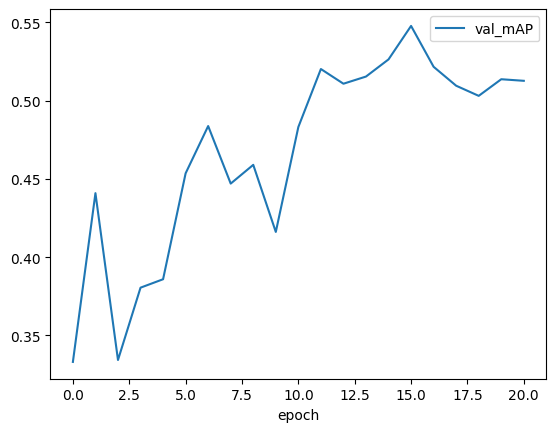

In [8]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv"))
loss_metrics = metrics[["epoch", "val_mAP"]].set_index("epoch")
plot = loss_metrics.plot()

## Test

Here we use the Trainer to run the model against the test data and collect the evaluation metrics.

In [9]:
scores = trainer.test(model, datamodule=datamodule, verbose=False)
mAPs = [scores[0]["test_mAP_class_" + str(i+1)] for i in range(len(dataset.classes)-1)]
df = pandas.DataFrame({"class": dataset.classes[1:], "mAP": mAPs}).set_index("class")
df

c:\Users\Bas\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


mAP
class           
banana  0.577222
orange  0.662152
apple   0.676643

## Inference

And now run inference on the inference images.

c:\Users\Bas\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


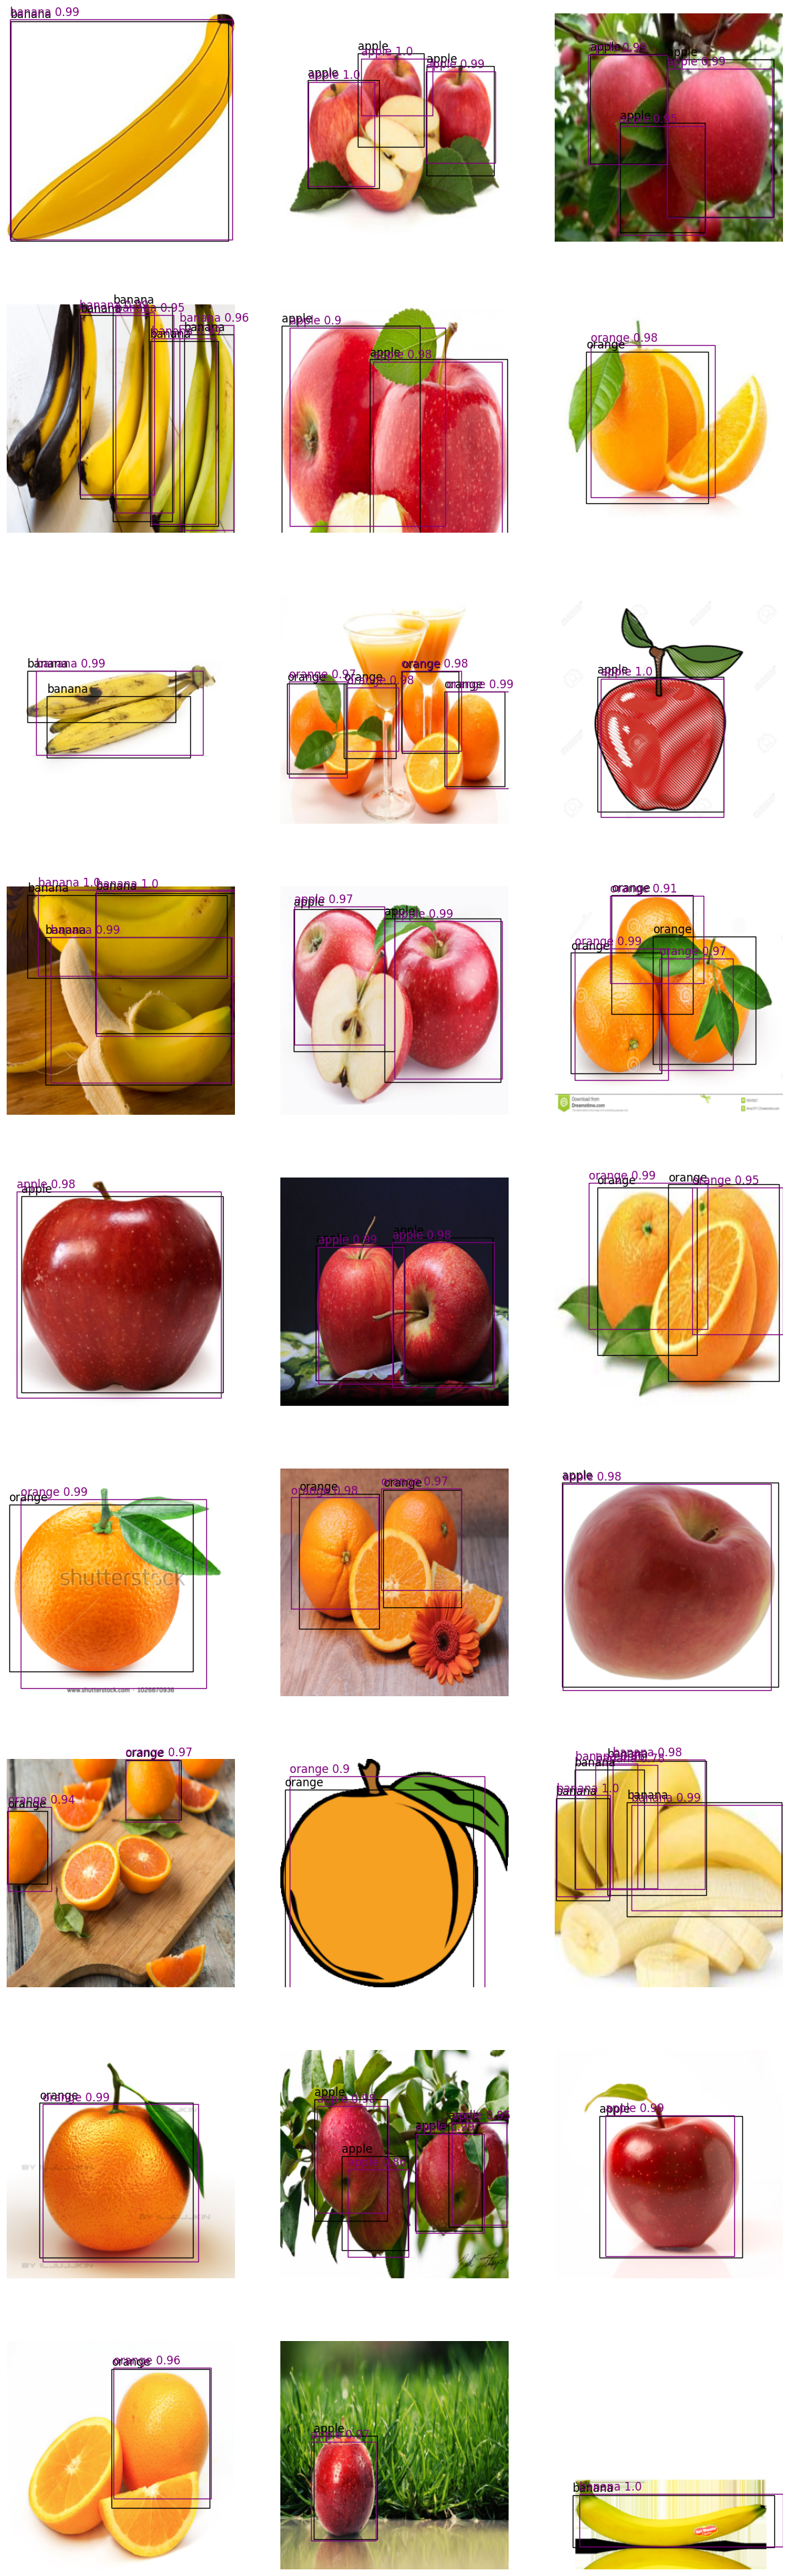

In [38]:
inference_dataloader = datamodule.test_dataloader()
preds = trainer.predict(model, dataloaders=inference_dataloader)

images = [d[0] for _, d in enumerate(inference_dataloader.dataset)]
targets = [d[1] for _, d in enumerate(inference_dataloader.dataset)]

fig, axes = plt.subplots(9, 3, figsize=(15, 50))
axes = axes.flatten()
for ax, image, prediction, target in zip(axes, images, preds[0], targets):
    ax.imshow(transforms.ToPILImage()(image))
    ax.axis("off")
    for truth, label in zip(target["boxes"], target["labels"]):
        xmin, ymin, xmax, ymax = truth[0], truth[1], truth[2], truth[3]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='black', linewidth=1)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, dataset.classes[label.item()], color='black', fontsize=12)
    for box, label, score in zip(prediction["boxes"], prediction["labels"], prediction["scores"]):
        if score < .7:
            continue
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='purple', linewidth=1)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, dataset.classes[label.item()] + " " + str(round(score.item(),2)), color='purple', fontsize=12)
